In [256]:
import numpy as np
import pandas as pd
import time
import numpy as np
import h5py
import matplotlib.pyplot as plt
import scipy
from PIL import Image
from scipy import ndimage


In [257]:
def load_data():
    file_name=r"C:\Users\Ravi\Anaconda3\my_learning\datasets\train_catvnoncat.h5"
    file_name_test=r"C:\Users\Ravi\Anaconda3\my_learning\datasets\test_catvnoncat.h5"
    train_dataset = h5py.File(file_name, "r")
    train_set_x_orig = np.array(train_dataset["train_set_x"][:]) # your train set features
    train_set_y_orig = np.array(train_dataset["train_set_y"][:]) # your train set labels

    test_dataset = h5py.File(file_name_test, "r")
    test_set_x_orig = np.array(test_dataset["test_set_x"][:]) # your test set features
    test_set_y_orig = np.array(test_dataset["test_set_y"][:]) # your test set labels

    classes = np.array(test_dataset["list_classes"][:]) # the list of classes
    
    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))
    
    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes

In [258]:
train_x_orig, train_y, test_x_orig, test_y, classes = load_data()
train_x_flatten = train_x_orig.reshape(train_x_orig.shape[0], -1).T   # The "-1" makes reshape flatten the remaining dimensions
test_x_flatten = test_x_orig.reshape(test_x_orig.shape[0], -1).T

# Standardize data to have feature values between 0 and 1.
train_x = train_x_flatten/255.
test_x = test_x_flatten/255.

In [259]:
def relu(x):
    return np.maximum(0,x),x

In [260]:
def sigmoid(x):
    return 1/(1+np.exp(-x)),x

In [261]:
def relu_backward(dA, cache):

    Z = cache
    dZ = np.array(dA, copy=True)  # just converting dz to a correct object.

    # When z <= 0, you should set dz to 0 as well.
    dZ[Z <= 0] = 0

    assert (dZ.shape == Z.shape)

    return dZ

In [262]:
def sigmoid_backward(dA, cache):
    
    Z = cache

    s = 1 / (1 + np.exp(-Z))
    dZ = dA * s * (1 - s)

    assert (dZ.shape == Z.shape)

    return dZ

In [263]:
def initialise_parametres(layer_dims):
    parameters = {}
    L = len(layer_dims)  # number of layers in the network
    for l in range(1, L):
        parameters['W' + str(l)] = np.random.randn(layer_dims[l], layer_dims[l - 1]) *0.01
        parameters['b' + str(l)] = np.zeros((layer_dims[l], 1))

        assert (parameters['W' + str(l)].shape == (layer_dims[l], layer_dims[l - 1]))
        assert (parameters['b' + str(l)].shape == (layer_dims[l], 1))

    return parameters

In [278]:
def forward_propagation(A, W, b):
    
    Z = W.dot(A) + b

    assert (Z.shape == (W.shape[0], A.shape[1]))
    cache = (A, W, b)

    return Z, cache

In [279]:
def forward_propagation_activation_based(A_prev, W, b, activation):

    if activation == "sigmoid":
        Z, linear_cache = forward_propagation(A_prev, W, b)
        A, activation_cache = sigmoid(Z)

    elif activation == "relu":
        Z, linear_cache = forward_propagation(A_prev, W, b)
        A, activation_cache = relu(Z)

    assert (A.shape == (W.shape[0], A_prev.shape[1]))
    cache = (linear_cache, activation_cache)

    return A, cache

In [266]:
def L_model_forward(X, parameters):
    caches = []
    A = X
    L = len(parameters) // 2  

    for l in range(1, L):
        A_prev = A
        A, cache = forward_propagation_activation_based(A_prev, parameters['W' + str(l)], parameters['b' + str(l)],
                                             activation="relu")
        caches.append(cache)

    # Implement LINEAR -> SIGMOID. Add "cache" to the "caches" list.
    AL, cache = forward_propagation_activation_based(A, parameters['W' + str(L)], parameters['b' + str(L)], activation="sigmoid")
    caches.append(cache)

    assert (AL.shape == (1, X.shape[1]))

    return AL, caches

In [267]:
def compute_cost(AL, Y):
    m = Y.shape[1]

    cost = (1. / m) * (-np.dot(Y, np.log(AL).T) - np.dot(1 - Y, np.log(1 - AL).T)) #cost_function

    cost = np.squeeze(cost) 
    assert (cost.shape == ())

    return cost

In [268]:
def backward_propagation(dZ, cache):
   
    A_prev, W, b = cache
    m = A_prev.shape[1]

    dW = 1. / m * np.dot(dZ, A_prev.T)
    db = 1. / m * np.sum(dZ, axis=1, keepdims=True)
    dA_prev = np.dot(W.T, dZ)

    return dA_prev, dW, db

In [269]:
def backward_propagation_activation_based(dA, cache, activation):
    
    linear_cache, activation_cache = cache

    if activation == "relu":
        dZ = relu_backward(dA, activation_cache)
        dA_prev, dW, db = backward_propagation(dZ, linear_cache)

    elif activation == "sigmoid":
        dZ = sigmoid_backward(dA, activation_cache)
        dA_prev, dW, db = backward_propagation(dZ, linear_cache)

    return dA_prev, dW, db

In [270]:
def L_model_backward(AL, Y, caches):
    grads = {}
    L = len(caches)  # the number of layers
    m = AL.shape[1]
    Y = Y.reshape(AL.shape)  # after this line, Y is the same shape as AL

    # Initializing the backpropagation
    dAL = - (np.divide(Y, AL) - np.divide(1 - Y, 1 - AL))

    # Lth layer (SIGMOID -> LINEAR) gradients. Inputs: "AL, Y, caches". Outputs: "grads["dAL"], grads["dWL"], grads["dbL"]
    current_cache = caches[L - 1]
    grads["dA" + str(L)], grads["dW" + str(L)], grads["db" + str(L)] = backward_propagation_activation_based(dAL, current_cache,
                                                                                                  activation="sigmoid")

    for l in reversed(range(L - 1)):
        # lth layer: (RELU -> LINEAR) gradients.
        current_cache = caches[l]
        dA_prev_temp, dW_temp, db_temp = backward_propagation_activation_based(grads["dA" + str(l + 2)], current_cache,
                                                                    activation="relu")
        grads["dA" + str(l + 1)] = dA_prev_temp
        grads["dW" + str(l + 1)] = dW_temp
        grads["db" + str(l + 1)] = db_temp

    return grads

In [271]:
def update_parameters(parameters, grads, learning_rate):

    L = len(parameters) // 2  # number of layers in the neural network

    for l in range(L):
        parameters["W" + str(l + 1)] = parameters["W" + str(l + 1)] - learning_rate * grads["dW" + str(l + 1)]
        parameters["b" + str(l + 1)] = parameters["b" + str(l + 1)] - learning_rate * grads["db" + str(l + 1)]

    return parameters

In [272]:
def predict(X, y, parameters):

    m = X.shape[1]
    n = len(parameters) // 2  # number of layers in the neural network
    p = np.zeros((1, m))

    # Forward propagation
    probas, caches = L_model_forward(X, parameters)

    # convert probas to 0/1 predictions
    for i in range(0, probas.shape[1]):
        if probas[0, i] > 0.75:
            p[0, i] = 1
        else:
            p[0, i] = 0

    # print results
    print("Accuracy: " + str(np.sum((p == y) / (m*1.0))))

    return p

In [276]:
def L_layer_model(X, Y, layers_dims, learning_rate = 0.0075, num_iterations = 3000, print_cost=False):#lr was 0.009

    costs = []                         # keep track of cost
    
    parameters = initialise_parametres(layers_dims)
    
    for i in range(0, num_iterations):

        AL, caches = L_model_forward(X, parameters)
        
        cost = compute_cost(AL, Y)

        grads = L_model_backward(AL, Y, caches)
    
        parameters = update_parameters(parameters, grads, learning_rate)
    
        if print_cost and i % 100 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
        if print_cost and i % 100 == 0:
            costs.append(cost)
            
    # plot the cost
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per tens)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    return parameters

Cost after iteration 0: 0.693147
Cost after iteration 100: 0.678000
Cost after iteration 200: 0.667584
Cost after iteration 300: 0.660405
Cost after iteration 400: 0.655441
Cost after iteration 500: 0.651999
Cost after iteration 600: 0.649603
Cost after iteration 700: 0.647931
Cost after iteration 800: 0.646761
Cost after iteration 900: 0.645940
Cost after iteration 1000: 0.645362
Cost after iteration 1100: 0.644956
Cost after iteration 1200: 0.644669
Cost after iteration 1300: 0.644466
Cost after iteration 1400: 0.644323
Cost after iteration 1500: 0.644222
Cost after iteration 1600: 0.644150
Cost after iteration 1700: 0.644099
Cost after iteration 1800: 0.644062
Cost after iteration 1900: 0.644037
Cost after iteration 2000: 0.644018
Cost after iteration 2100: 0.644006
Cost after iteration 2200: 0.643996
Cost after iteration 2300: 0.643990
Cost after iteration 2400: 0.643985


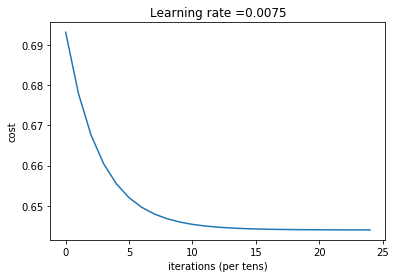

In [282]:
parameters = L_layer_model(train_x, train_y, [12288, 20, 7, 5, 1], num_iterations = 2500, print_cost = True)

In [281]:
pred_train = predict(train_x, train_y, parameters)

Accuracy: 0.6555023923444976


In [86]:
def initialise_parametres(list_of_hidden):
    w=[]
    b=[]
    for i in range(1,len(list_of_hidden)):
        w.append(np.random.randn(list_of_hidden[i],list_of_hidden[i-1]))
        b.append(np.zeros((list_of_hidden[i],1)))
    parameters={
        "w":w,
        "b":b
    }
    return parameters

In [87]:
def relu(x):
    return np.maximum(0,x)

In [118]:
def sigmoid(x):
    return 1/(1+np.exp(-x))

In [147]:
def forward_propagate(parameters,x,y):
    z=[]
    a=[]
    x_prev=x
    w=parameters["w"]
    b=parameters["b"]
    for i in range(0,len(w)-1):
        z.append(np.dot(w[i],x_prev)+b[i])
        x_prev=relu(z[i])
        a.append(x_prev)
    x_prev=a[-1]
    z.append(np.dot(w[len(w)-1],x_prev)+b[len(w)-1])
    a.append(sigmoid(z[-1]))
    return z,a

In [187]:
def compute_cost(a,Y):
    m = Y.shape[1]
    print (m)
    cost = -(np.dot(Y,np.log(a[-1].T))+np.dot(1-Y,np.log(1-a[-1].T)))/m
    cost = np.squeeze(cost)
    print (cost)
    print(len(a[-1][0]))
    return cost

In [188]:
parameters=initialise_parametres([len(train_x),2,4,1])
z,a=forward_propagate(parameters,train_x, train_y)

In [189]:
cost=compute_cost(a,train_y)

209
1.3957865281680026
209


In [194]:
def relu_backward(dA, Z):
    """
    Implement the backward propagation for a single RELU unit.
    Arguments:
    dA -- post-activation gradient, of any shape
    cache -- 'Z' where we store for computing backward propagation efficiently
    Returns:
    dZ -- Gradient of the cost with respect to Z
    """

    dZ = np.array(dA, copy=True)  # just converting dz to a correct object.

    # When z <= 0, you should set dz to 0 as well.
    dZ[Z <= 0] = 0

    assert (dZ.shape == Z.shape)

    return dZ

In [195]:
def sigmoid_backward(dA, Z):

    s = 1 / (1 + np.exp(-Z))
    dZ = dA * s * (1 - s)

    assert (dZ.shape == Z.shape)

    return dZ


In [239]:
def backward_prop(a,z,y,parameters):
    print (len(z))
    m=len(z[0][0])
    w=parameters["w"]
    dw,da,db=[],[],[]
    da.append(- (np.divide(y, a[-1]) - np.divide(1 - y, 1 - a[-1])))
    dz=[]
    dz.append(sigmoid_backward(da[0], z[-1]))
    db.append( 1. / m * np.sum(dz[0], axis=1, keepdims=True))
    dw.append(1. / m * np.dot(dz[0], a[-1].T))
    print (dw)
    for l in range(len(z)-1, 0, -1):
        print (l)
        da.append(np.dot(w[l-1].T, dz[len(z)-l-1]))
        dz.append(relu_backward(da[len(z)-l-1], z[l]))
        db.append( 1. / m * np.sum(dz[len(z)-l], axis=1, keepdims=True))
        dw.append(1. / m * np.dot(dz[len(z)-l], a[l].T))
        pass
    

In [240]:
backward_prop(a,z,train_y,parameters)

3
[array([[0.07479369]])]
2


ValueError: shapes (2,4) and (1,209) not aligned: 4 (dim 1) != 1 (dim 0)

In [ ]:
def linear_backward(dZ, cache):
    """
    Implement the linear portion of backward propagation for a single layer (layer l)
    Arguments:
    dZ -- Gradient of the cost with respect to the linear output (of current layer l)
    cache -- tuple of values (A_prev, W, b) coming from the forward propagation in the current layer
    Returns:
    dA_prev -- Gradient of the cost with respect to the activation (of the previous layer l-1), same shape as A_prev
    dW -- Gradient of the cost with respect to W (current layer l), same shape as W
    db -- Gradient of the cost with respect to b (current layer l), same shape as b
    """
    A_prev, W, b = cache
    m = A_prev.shape[1]

    dW = 1. / m * np.dot(dZ, A_prev.T)
    db = 1. / m * np.sum(dZ, axis=1, keepdims=True)
    dA_prev = np.dot(W.T, dZ)

    assert (dA_prev.shape == A_prev.shape)
    assert (dW.shape == W.shape)
    assert (db.shape == b.shape)

    return dA_prev, dW, db